In [14]:
#!/usr/bin/env python3

import pickle as pk
import sys
import time as tm
from argparse import ArgumentParser

import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from captum.attr import FeatureAblation
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data.dataset import Dataset

sns.set_theme()

batch_size = 70
num_workers = 10

In [ ]:
p_latent_space = 20
num_epochs = 10
n_phen = 25

In [ ]:


class dataset_pheno(Dataset):
    """a class for importing phenotype data.
    It expects a pickled object that is organized as a list of tensors:
    genotypes[n_animals, n_loci, n_alleles] (one hot at allelic state)
    gen_locs[n_animals, n_loci] (index of allelic state)
    weights[n_phens, n_loci, n_alleles] float weight for allelic contribution to phen
    phens[n_animals,n_phens] float value for phenotype
    indexes_of_loci_influencing_phen[n_phens,n_loci_ip] integer indicies of loci that influence a phenotype
    interaction_matrix[FILL THIS IN]
    pleiotropy_matrix[n_phens, n_phens, gen_index]"""

    def __init__(self, data_file, n_phens):
        self.datset = pk.load(open(data_file, "rb"))
        self.phens = torch.tensor(np.array(self.datset["phenotypes"]), dtype=torch.float32)
        self.data_file = data_file
        self.n_phens = n_phens

    def __len__(self):
        return len(self.phens)

    def __getitem__(self, idx):
        phenotypes = self.phens[idx][: self.n_phens]
        return phenotypes


In [34]:

#train_data_pheno = dataset_pheno('arapheno_scaled_study3_4_5_lowNA_pheno.pk', n_phens=25)
#test_data_pheno = dataset_pheno('arapheno_scaled_study3_4_5_highNA_pheno.pk', n_phens=25)

train_data_pheno = dataset_pheno('WF_Ne100k_samples_10k_H2_05_qtl_10k_corA_02_25traits_train.pk', n_phens=25)
test_data_pheno = dataset_pheno('WF_Ne100k_samples_10k_H2_05_qtl_10k_corA_02_25traits_test.pk', n_phens=25)


In [19]:
# setting device on GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

train_loader_pheno = torch.utils.data.DataLoader(
    dataset=train_data_pheno, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
test_loader_pheno = torch.utils.data.DataLoader(
    dataset=test_data_pheno, batch_size=batch_size, num_workers=num_workers, shuffle=True
)

# how many samples per batch to load


Using device: cuda


In [20]:

# encoder
class Q_net(nn.Module):
    def __init__(self, phen_dim=None, N=None):
        super().__init__()
        if N is None:
            N = p_latent_space
        if phen_dim is None:
            phen_dim = n_phen

        batchnorm_momentum = 0.8
        latent_dim = p_latent_space
        self.encoder = nn.Sequential(
            nn.Linear(in_features=phen_dim, out_features=N),
            nn.BatchNorm1d(N, momentum=batchnorm_momentum),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Linear(in_features=N, out_features=latent_dim),
            nn.BatchNorm1d(latent_dim, momentum=batchnorm_momentum),
            nn.LeakyReLU(0.01, inplace=True),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


# decoder
class P_net(nn.Module):
    def __init__(self, phen_dim=None, N=None):
        if N is None:
            N = p_latent_space
        if phen_dim is None:
            phen_dim = n_phen

        out_phen_dim = n_phen
        #vabs.n_locs * vabs.n_alleles
        latent_dim = p_latent_space

        batchnorm_momentum = 0.8

        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=N),
            nn.BatchNorm1d(N, momentum=batchnorm_momentum),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=N, out_features=out_phen_dim),
        )

    def forward(self, x):
        x = self.decoder(x)
        return x


In [21]:
# set minimum variable
EPS = 1e-15
reg_lr = 0.001
adam_b = (0.5, 0.999)


# initialize all networks
Q = Q_net()
P = P_net()

Q.to(device)
P.to(device)

optim_P = torch.optim.Adam(P.parameters(), lr=reg_lr, betas=adam_b)
optim_Q_enc = torch.optim.Adam(Q.parameters(), lr=reg_lr, betas=adam_b)

In [22]:

# train phen autoencoder
n_phens = n_phen
n_phens_pred = n_phen
rcon_loss = []

start_time = tm.time()

for n in range(num_epochs):
    for i, (phens) in enumerate(train_loader_pheno):
        phens = phens[:, :n_phens]
        #print(phens)
        phens = phens.to(device)  # move data to GPU if it is there
        batch_size = phens.shape[0]  # redefine batch size here to allow for incomplete batches

        # reconstruction loss
        Q.zero_grad()
        P.zero_grad()

        noise_phens = phens + (0.001**0.5) * torch.randn(phens.shape).to(device)

        z_sample = Q(noise_phens)
        X_sample = P(z_sample)

        # recon_loss = F.mse_loss(X_sample+EPS,phens[:,:n_phens_pred]+EPS)

        recon_loss = F.l1_loss(X_sample + EPS, phens[:, :n_phens_pred] + EPS)

        l1_reg = torch.linalg.norm(torch.sum(Q.encoder[0].weight, axis=0), 1)
        l2_reg = torch.linalg.norm(torch.sum(Q.encoder[0].weight, axis=0), 2)

        recon_loss = recon_loss + l1_reg * 0.0000000001 + l2_reg * 0.000000001


        rcon_loss.append(float(recon_loss.detach()))

        recon_loss.backward()
        optim_Q_enc.step()
        optim_P.step()

    cur_time = tm.time() - start_time
    start_time = tm.time()
    print(
        "Epoch num: "
        + str(n)
        + " batchno "
        + str(i)
        + " r_con_loss: "
        + str(rcon_loss[-1])
        + " epoch duration: "
        + str(cur_time)
    )


Epoch num: 0 batchno 199 r_con_loss: 1.8730820417404175 epoch duration: 3.2667593955993652
Epoch num: 1 batchno 199 r_con_loss: 1.7554824352264404 epoch duration: 2.57777738571167
Epoch num: 2 batchno 199 r_con_loss: 1.8494495153427124 epoch duration: 2.574150323867798
Epoch num: 3 batchno 199 r_con_loss: 1.7792226076126099 epoch duration: 2.6049578189849854
Epoch num: 4 batchno 199 r_con_loss: 1.744001865386963 epoch duration: 2.5849244594573975
Epoch num: 5 batchno 199 r_con_loss: 1.7340253591537476 epoch duration: 2.609386444091797
Epoch num: 6 batchno 199 r_con_loss: 1.7114530801773071 epoch duration: 2.557328462600708
Epoch num: 7 batchno 199 r_con_loss: 1.6770888566970825 epoch duration: 2.5874617099761963
Epoch num: 8 batchno 199 r_con_loss: 1.6342525482177734 epoch duration: 2.606893301010132
Epoch num: 9 batchno 199 r_con_loss: 1.6518843173980713 epoch duration: 2.597874402999878


In [23]:

# test the p-p prediction
Q.eval()

phen_encodings = []
phens = []
phen_latent = []

for dat in test_loader_pheno:
    ph = dat
    ph = ph.to(device)
    batch_size = ph.shape[0]
    z_sample = Q(ph)
    X_sample = P(z_sample)
    phens += list(ph.detach().cpu().numpy())
    phen_encodings += list(X_sample.detach().cpu().numpy())
    phen_latent += list(z_sample.detach().cpu().numpy())


In [25]:
phens_df = pd.DataFrame(phens)
#print((phens_df))

phen_encodings_df = pd.DataFrame(phen_encodings)
#print((phen_encodings_df))

[-1.6783103942871094, -1.1226017475128174, 0.4141637682914734, 0.7980697154998779, -1.4021093845367432, 0.0036919713020324707, -1.5186505317687988, -1.8266174793243408, -3.1864013671875, -1.9782497882843018, -24.3748722076416, -7.15608024597168, -9.528851509094238, -1.6824517250061035, -8.235037803649902, -0.978678822517395, -0.005555152893066406, -3.487326145172119, -3.0133614540100098, -4.534521102905273, -45.21472930908203, -38.42100143432617, -7.299818992614746, -33.98124694824219, -7.77370548248291]


(array([ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  5., 15.]),
 array([-45.21472931, -40.61344941, -36.0121695 , -31.4108896 ,
        -26.8096097 , -22.2083298 , -17.60704989, -13.00576999,
         -8.40449009,  -3.80321019,   0.79806972]),
 <BarContainer object of 10 artists>)

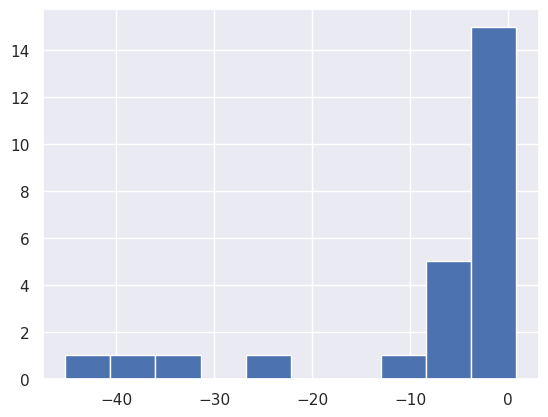

In [26]:
errs = [r2_score(phen_encodings_df[n], phens_df[n]) for n in range(n_phen )]
print(errs)
plt.hist(errs)

In [33]:
#plt.scatter(phen_encodings_df[1], phens_df[1])


#plot feature ablation importance by predicted feature


plt.figure(figsize=(500, n_phen))

for i in range(n_phen):
    plt.subplot(1, n_phen, i+1)
    plt.scatter(phen_encodings_df[i], phens_df[i])
    plt.axline((0, 0), slope=1)


2000
1.6518843173980713


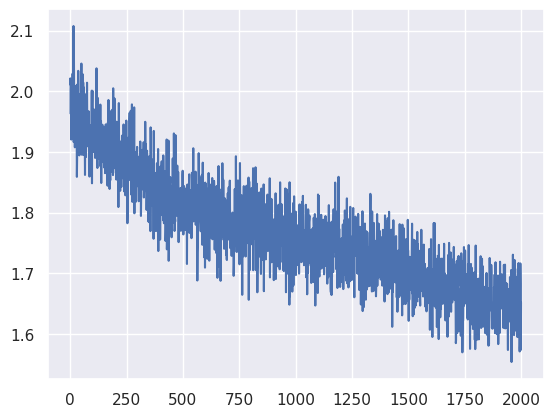

In [28]:
plt.plot(rcon_loss)
print(len(rcon_loss))
print(rcon_loss[-1])

<Axes: >

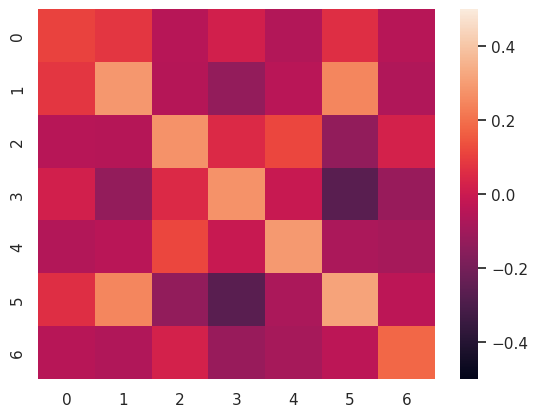

In [ ]:

W = P.state_dict()['decoder.0.weight'].cpu()
W_trans = W.T
S = np.log(np.matmul(W_trans, W) + 1)
sns.heatmap(S, vmin=-0.5, vmax=0.5)


In [ ]:
#define MSE with no averaging to keep phenotypes loss seperate per phenotype
def sequential_forward_attr_phen_phen(input, phens):
    """puts together two models for use of captum feature importance"""
    mod_2_input = Q(input)
    X_sample = P(mod_2_input)
    output = F.mse_loss(X_sample + EPS, phens[:, :n_phens_pred] + EPS, reduction="none")
    return output


fa_p = FeatureAblation(sequential_forward_attr_phen_phen)


In [ ]:
fa_attr = []


for dat in test_loader_pheno:
    ph = dat
    ph = ph.to(device)
    batch_size = ph.shape[0]
    z_sample = Q(ph)
    X_sample = P(z_sample)
    phens += list(ph.detach().cpu().numpy())
    phen_encodings += list(X_sample.detach().cpu().numpy())
    phen_latent += list(z_sample.detach().cpu().numpy())
    fa_attr.append(list(fa_p.attribute(inputs=(ph, ph),perturbations_per_eval = 1)[0].squeeze().detach().cpu().numpy()))

/opt/conda/envs/gpatlas/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
###########
#iterate over all batches
#change to take mean of batch
df_batch = []
means = []
dfmean = pd.DataFrame()

for sublist in fa_attr: #iterate over each batch
    df_batch = pd.DataFrame(sublist)
    for i in range(n_phen): #iterate over every one of 5 phenotypes
        means = pd.DataFrame(df_batch.iloc[i::n_phen].mean(axis=0)).T #calculate mean importance by averaging over the 30 observations in the batch
        means['input'] = i #column to keep track of which output feature this data relates to
        dfmean = pd.concat([dfmean, means])


In [ ]:
dfmean

0         1  input
0 -5.390865 -0.634668      0
0  0.064277 -6.780875      1
0 -8.289792 -0.084055      0
0 -0.549959 -4.746102      1
0 -5.009411 -0.930462      0
0 -0.092804 -6.426135      1
0 -5.029456 -0.805414      0
0 -0.377903 -5.759237      1
0 -6.817199 -0.309998      0
0 -0.327151 -4.224118      1
0 -4.717241 -1.210750      0
0 -0.008620 -6.972697      1
0 -5.981602  0.235135      0
0  0.024066 -8.185253      1
0 -7.738105  0.041290      0
0  0.161328 -6.595308      1
0 -5.056661 -0.974853      0
0  0.093153 -7.761947      1

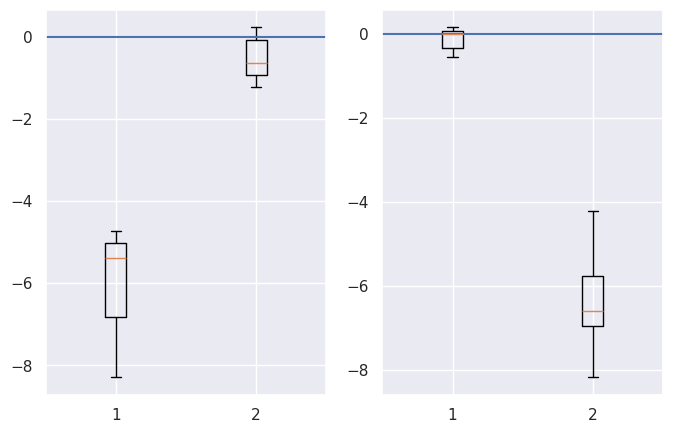

In [ ]:
#plot feature ablation importance by predicted feature

plt.figure(figsize=(21, 5))

for i in range(n_phen):
    plt.subplot(1, 5, i+1)
    dfplot = dfmean.loc[dfmean['input'] == i]
    dfplot = dfplot.iloc[:, :-1]
    plt.boxplot(dfplot)
    plt.axhline(y = 0)